# 03. Prompt Engineering and Reflection

This tutorial dives into prompt engineering and reflection-driven workflows for language-model agents. We survey the research foundations, implement multiple critique strategies, and compare how each method improves a realistic customer-support scenario. The goal is to build intuition for when to keep prompts simple, when to add structured self-reflection, and how to layer multiple models for critique, debate, or automated prompt editing. Let's see how we can use techniques of prompt engineering and reflection with self-improvement loops to improve performance of vanilla agents. 

Prompt engineering and reflection are two complementary strategies that shape how language-model agents reason and improve. Prompt engineering focuses on designing effective instructions — from minimal zero-shot prompts to structured few-shot or tool-augmented formats like ReAct (more on it later) — so the model interprets intent correctly and produces reliable outputs. Reflection, on the other hand, introduces feedback and self-evaluation: the model (or a helper model) critiques, revises, or explains its own reasoning to refine future responses. Together, these techniques transform static prompting into a dynamic process of learning from one’s own outputs, bridging the gap between single-pass generation and adaptive, multi-step intelligence.

I highly recommend watching the videos from [Tina Huang](https://youtu.be/p09yRj47kNM?si=kyOFdrzBVcobIt1r) and [Andrew Ng](https://learn.deeplearning.ai/courses/agentic-ai/lesson/shknq1/reflection-to-improve-outputs-of-a-task).

## Exemplar Scenarios

**Tasks**

- Numeric sorting (lists of length up to ~80): tests instruction-following, formatting, and error-checking under length.
- Sentiment classification (short, “hard” app-review snippets): tests boundary cases (“mixed sentiment”, negations, subtle complaints).

**Inputs**
- If present, we use cached jsonl datasets; otherwise we synthesize ~50 examples per task (already handled in the next cell).

**Metrics**
- Accuracy
    - Sorting: exact match to ascending order (converted to floats; ignores whitespace).
    - Sentiment: exact match to positive|negative.
- Latency (s): total wall-clock time across the dataset.
- Format adherence (implicit): Pydantic schema validation fails loudly if the model drifts from required JSON.

> **Note** on `@agent.output_validator` in Pydantic AI. 
> 
>In Pydantic-AI, every `Agent` can define an **optional post-processing hook** using the `@agent.output_validator` decorator. This function receives two arguments—`ctx` (the current `RunContext`, which includes model info and inputs) and `result` (the parsed Pydantic object)—and lets you **programmatically verify, transform, or reject** invalid outputs before returning them to the user.
If the validator raises a `ModelRetry`, the same prompt is automatically retried with an adjusted instruction, allowing for **self-correcting generations** (for example, ensuring that the sentiment label is strictly `"positive"` or `"negative"`). This pattern makes schema validation both *enforceable* and *recoverable* within a single declarative agent definition.


In [1]:
import os, time, random, re, math, json
from typing import List, Literal, Tuple, Optional
from dataclasses import dataclass
from datasets import Dataset, load_dataset
from tqdm import tqdm, trange

from pydantic import BaseModel, Field
from pydantic_ai import Agent, RunContext, ModelRetry

from dotenv import load_dotenv
import nest_asyncio
nest_asyncio.apply()

load_dotenv()

DEFAULT_MODEL_ID = "openrouter:openai/gpt-3.5-turbo"
CRITIC_MODEL_ID  = "openrouter:google/gemini-2.5-flash" 
DSET_MODEL_ID    = "openrouter:google/gemini-2.5-flash" # model to create datasets

print("Worker:", DEFAULT_MODEL_ID, "| Critic/Judge:", CRITIC_MODEL_ID)

RANDOM_SEED = 7
random.seed(RANDOM_SEED)
MAX_LIST_LEN = 80

SORTING_EVAL_PATH = "data/sorting_eval.jsonl"
SENTIMENT_EVAL_PATH = "data/sentiment_eval.jsonl"

# Sorting task
if os.path.exists(SORTING_EVAL_PATH):
    sort_eval = load_dataset('json', data_files=SORTING_EVAL_PATH, split='train')
else:
    sort_items = []
    for _ in range(50):
        list_len = random.randint(MAX_LIST_LEN // 10, MAX_LIST_LEN)
        numbers = [random.uniform(-20, 30) for _ in range(list_len)]
        sort_items.append({
            "inp": numbers, "out": sorted(numbers)
        })
    sort_eval = Dataset.from_list(sort_items)
    sort_eval.to_json(SORTING_EVAL_PATH)


# Sentiment task
if os.path.exists(SENTIMENT_EVAL_PATH):
    sent_eval = load_dataset('json', data_files=SENTIMENT_EVAL_PATH, split='train')
else:
    sent_items = []

    sentiment_items = [
        {"text": "Love the UI, super smooth!", "label": "positive"},
        {"text": "Terrible lag and frequent crashes.", "label": "negative"},
        {"text": "Pretty good overall, but the ads are annoying.", "label": "positive"},
        {"text": "Bad update. The app freezes on login.", "label": "negative"},
    ]
    sentiment_items = "\n".join([json.dumps(i) for i in sentiment_items])

    @dataclass
    class Sentiment_Item(BaseModel):
        text: str = Field("Input text to classify")
        label: str = Field("Ground truth sentiment as positive or negative.")

    dset_agent = Agent(
        model=DSET_MODEL_ID,
        system_prompt=f"You are a dataset generator to evaluate an agent that does sentiment anlaysis. "
            "Make the dataset hard. Some examples: {sentiment_items}. \n\n Give one example only, long and convoluted text.",
        output_type=Sentiment_Item,
        retries=3
    )

    @dset_agent.output_validator
    def validate_result(ctx: RunContext, result: Sentiment_Item):
        if result.label not in ['positive', 'negative']:
            raise ModelRetry(f"Label should be either of 'positive' or 'negative'.")
        else:
            return result

    sent_items = []
    for _ in trange(50):
        response = dset_agent.run_sync("create a single hard dataset example.")
        sent_item = response.output
        sent_items.append(sent_item.model_dump())
    sent_eval = Dataset.from_list(sent_items)
    sent_eval.to_json(SENTIMENT_EVAL_PATH)

print("Example sorting sample:", sort_eval[0])
print("Example sentiment sample:", sent_eval[0])

Worker: openrouter:openai/gpt-3.5-turbo | Critic/Judge: openrouter:google/gemini-2.5-flash
Example sorting sample: {'inp': [27.3932680305, -0.2588251788, -17.5856788187, 21.0637145996, -15.293497903, 9.1394002952, 25.4852031572, -9.2650909582, -15.7026383155, 0.9086075685, -7.9668499936, 7.5523626896, -17.0444746961, 8.2726847097, 27.3724850354, 11.5312957866, 9.149845223, -16.9068975832, 9.277071132, -17.5205343305, -8.9459088271, 7.8332448969, -13.3412591779, 0.9569521786, 7.0342942766, 8.5456844823, 8.0128638506, 14.1001347381, -14.8472143778, 8.5602195706, -10.6064486606, -15.1284712003, 15.6055382873, 8.2184146567, 10.9504796587, 4.8207247557, 6.586012329, 18.861438749, 3.280093292, 26.1720691819, -1.9208822028, -7.5786707571, -11.0116625208, 18.9914815292, -15.9072494602, -4.9875440727, 4.7558179778, -2.8262155021, 2.4417095214], 'out': [-17.5856788187, -17.5205343305, -17.0444746961, -16.9068975832, -15.9072494602, -15.7026383155, -15.293497903, -15.1284712003, -14.8472143778, -

## Pydantic Schemas

To ensure reproducibility, safety, and interpretable agent behavior, all model responses in this tutorial are **validated using Pydantic schemas**.
Each reflection or reasoning step outputs a typed object that enforces structure (e.g., JSON keys, numeric lists, sentiment labels).
This provides automatic validation, retry logic, and clear boundaries between reasoning, critique, and evaluation stages.

We define core dataclasses and Pydantic models for:

* **Task outputs** — e.g., `SortAnswer` and `SentimentAnswer`
* **Critique and refinement loops** — e.g., `CritiqueFixSort`, `CritiqueFixSent`
* **Meta-reasoning structures** — `RationaleAnswer`, `ThoughtCandidate`, `JudgePick`, and `PromptRewrite`
* **Benchmark tracking** — `RunResult` captures accuracy, latency, and raw predictions

After defining these schemas, we’ll implement reusable benchmarking functions:

* `run_sort_async()` evaluates list-sorting tasks.
* `run_sent_async()` evaluates sentiment-classification tasks.

These utility functions time each agent’s responses, compute task-specific accuracy, and help us compare reflection strategies (zero-shot, few-shot, debate, tree-of-thought, etc.) in a unified way.

> **Note:**  
> In Pydantic AI, every `Agent` exposes both **sync** (`run_sync()`) and **async** (`run()`) methods.  
> - `run_sync()` blocks until the LLM response is returned — simple but sequential.  
> - `run()` is **awaitable** and non-blocking, letting you launch many requests in parallel using `asyncio.gather`.  
>  
> When using `async def` functions, you must `await agent.run(prompt)` to get the response.  
> The returned object contains:
> - `.data` or `.output`: parsed output matching your `Agent[result_type]` schema.  
> - `.raw`: the full text response from the model (for debugging).  
>  
> In the following async version, we use `await agent.run(...)` inside `asyncio.gather` to parallelize inference across items.

In [2]:
import asyncio
from tqdm.asyncio import tqdm_asyncio

# --- Core outputs ---
class SortAnswer(BaseModel):
    """Strict structured output for sorting."""
    numbers: List[float] = Field(..., description="Numbers sorted ascending")

class SentimentAnswer(BaseModel):
    label: Literal["positive", "negative"]

# --- Run Result --- 
@dataclass
class RunResult:
    accuracy: float
    raw: List

# --- Benchmarking ---
async def run_sort_async(agent: Agent, items, concurrency: int = 50):
    sem = asyncio.Semaphore(concurrency)

    async def one(ex):
        async with sem:
            res = await agent.run(f"Sort this list: {ex['inp']}")
            out = getattr(res, "data", getattr(res, "output"))
            return out.numbers

    preds = await tqdm_asyncio.gather(*(one(ex) for ex in items), desc="sort")
    acc = sum([list(map(float, p)) == list(map(float, ex["out"])) for p, ex in zip(preds, items)]) / len(items)
    return RunResult(acc, preds)

async def run_sent_async(agent: Agent, dset, concurrency: int = 50):
    sem = asyncio.Semaphore(concurrency)

    async def one(ex):
        async with sem:
            r = await agent.run(f"Review: {ex['text']}")
            out = getattr(r, "data", getattr(r, "output"))
            return out.label

    preds = await tqdm_asyncio.gather(*(one(ex) for ex in dset), desc="sent")
    acc = sum([p == ex["label"] for p, ex in zip(preds, dset)]) / len(dset)
    return RunResult(acc, preds)

## Baseline Prompting Strategies

Before diving into reflection and self-improvement loops, it’s useful to establish **prompting baselines** — the simplest ways an LLM can be guided to solve a task. These serve as reference points for evaluating reflection, debate, or multi-step reasoning later.

1. **Zero-shot prompting:** 
    - The model receives **only the task description** — no examples or prior context. 
    - It relies entirely on its pretraining to infer intent and output format.
    - *Best for simple, well-known tasks (e.g., “Sort this list ascending”).*

2. **Few-shot prompting:** 
    - We provide **a few labeled examples** (“shots”) in the prompt before the query. 
    - The model learns the pattern **in context**, mimicking how examples map to outputs.
    - *This mechanism is called **in-context learning (ICL)** — the model adapts behavior dynamically from the examples without any parameter updates.*

3. **ReAct prompting:** 
    - **ReAct (Reason + Act)** combines short “thought” steps with **tool use** or observations. See [(Yao et al. 2023) ](https://arxiv.org/pdf/2210.03629)for more details.
    - The model alternates between reasoning (“thought: ...”) and taking an **action** (“act: use tool ...”), then refines its answer based on the feedback.
    - *Ideal for tool-augmented agents or reasoning tasks requiring intermediate steps.*


*Together, these baselines — zero-shot, few-shot, and ReAct — represent the evolution from static prompting to dynamic reasoning and interaction.*


Let's start with zero-shot prompting.

### Zero-shot prompting

In [ ]:
sort_worker_0shot = Agent(
    model=DEFAULT_MODEL_ID,
    system_prompt="You are a precise assistant. Sort numeric lists ascending and return as the schema required.",
    output_type=SortAnswer,
    retries=3
)

sorting_score_0shot = await run_sort_async(sort_worker_0shot, sort_eval)
print("Zero-shot sorting:", sorting_score_0shot.accuracy)

sent_worker_0shot = Agent(
    model=DEFAULT_MODEL_ID,
    system_prompt="Classify app-review sentiment as 'positive' or 'negative'. Return JSON: {label:'positive'|'negative'}.",
    output_type=SentimentAnswer,
    retries=3
)

sentiment_score_0shot = await run_sent_async(sent_worker_0shot, sent_eval)
print("Zero-shot sentiment:", sentiment_score_0shot.accuracy)

sort: 100%|██████████| 50/50 [00:12<00:00,  3.95it/s]


Zero-shot sorting: 0.62


sent: 100%|██████████| 50/50 [00:16<00:00,  3.02it/s]

Zero-shot sentiment: 0.92


Not a bad start, but let's see how we can improve scores using few-shot prompting.

### Few-shot prompting

In [ ]:
FEW_SHOTS_SORT = [
    {"input": [7, 7, 1, 10, 8],                "output": [1, 7, 7, 8, 10]},        # ties + medium len
    {"input": [3.2, 3.1, -1.0, 0.0, -5.5],     "output": [-5.5, -1.0, 0.0, 3.1, 3.2]},  # floats + negatives
    {"input": [12, -3, 4, 4, 4, 9, 0, -2],     "output": [-3, -2, 0, 4, 4, 4, 9, 12]}, # duplicates + mixed
]

sort_worker_fewshot = Agent(
    model=DEFAULT_MODEL_ID,
    system_prompt=(
        "Sort numeric lists ascending. Return JSON: {numbers:[...]}. Examples:\n" +
        "\n".join([f"- input={ex['input']} -> numbers={ex['output']}" for ex in FEW_SHOTS_SORT])
    ),
    output_type=SortAnswer,
    retries=3
)

sorting_score_fewshot = await run_sort_async(sort_worker_fewshot, sort_eval)
print("Few-shot sorting:", sorting_score_fewshot.accuracy)

FEW_SHOTS_SENT = [
    {"text": "UI is smooth but the latest update broke export.", "label": "negative"},  # mixed sentiment → negative
    {"text": "Setup took minutes and it just works every day.",  "label": "positive"},
    {"text": "Ads cover the buttons and it keeps freezing.",     "label": "negative"},  # concrete issues
    {"text": "After the patch, performance improved a lot!",     "label": "positive"},
]

sent_worker_fewshot = Agent(
    model=DEFAULT_MODEL_ID,
    system_prompt=(
        "Classify app-review sentiment. Return JSON: {label:'positive'|'negative'}.\nExamples:\n" +
        "\n".join([f"- text={ex['text']} -> label={ex['label']}" for ex in FEW_SHOTS_SENT])
    ),
    output_type=SentimentAnswer,
    retries=3
)

sentiment_score_fewshot = await run_sent_async(sent_worker_fewshot, sent_eval)
print("Few-shot sentiment:", sentiment_score_fewshot.accuracy)

sort: 100%|██████████| 50/50 [00:15<00:00,  3.25it/s]


Few-shot sorting: 0.64


sent: 100%|██████████| 50/50 [00:09<00:00,  5.54it/s]

Few-shot sentiment: 0.93


Marginal improvement from zero-shot. 

### ReAct prompting

Let's implement ReAct prompting now with a loop until it reaches a solution.  We’ll implement two ReAct agents:

* **Sorting agent** → uses a `stats_numbers` tool to compute simple statistics before outputting the final sorted list.
* **Sentiment agent** → uses a `keyword_pulse` tool that counts positive/negative keywords before giving the final label.

Each agent runs up to two reasoning–action iterations per example, using **Pydantic-AI** schemas for structured traces and outputs.

In [116]:
import asyncio, re, json, statistics as st
from typing import Literal, Optional, Dict, Any, List
from pydantic import BaseModel
from tqdm.asyncio import tqdm_asyncio
from pydantic_ai import Agent

# ReAct schemas
class Action(BaseModel):
    tool: Literal["stats_numbers", "keyword_pulse"]
    args: Dict[str, Any]

class Step(BaseModel):
    thought: str
    action: Optional[Action] = None
    observation: Optional[str] = None

class ReActTraceSort(BaseModel):
    steps: List[Step]
    final: List[float]

class ReActTraceSent(BaseModel):
    steps: List[Step]
    final: str

# Tools
def tool_stats_numbers(numbers: List[float]) -> str:
    if not numbers: return json.dumps({"len":0})
    return json.dumps({"len":len(numbers),"min":min(numbers),"max":max(numbers),"mean":round(st.fmean(numbers),3)})

POS_HINTS = {"love","great","smooth","fast","awesome","nice","happy"}
NEG_HINTS = {"terrible","awful","bad","freezes","crash","crashes","lag","bug","slow","annoy"}
def tool_keyword_pulse(text: str) -> str:
    tl = text.lower().split()
    pos = sum(w in POS_HINTS for w in tl); neg = sum(w in NEG_HINTS for w in tl)
    return json.dumps({"pos":pos,"neg":neg})

# Agents
react_sort = Agent(
    model=DEFAULT_MODEL_ID,
    system_prompt=(
        "You are a ReAct agent. Think briefly, optionally call a tool, then output FINAL.\n"
        "Tools available:\n"
        "- stats_numbers: args {numbers: List[float]} -> returns JSON {len,min,max,mean}\n"
        "You must still produce the exact ascending sequence yourself.\n"
        "Return JSON {steps:[{thought,action?,observation?},...], final:str}. Do not run tools, only give this JSON."
    ),
    output_type=ReActTraceSort,
    retries=4
)
react_sent = Agent(
    model=DEFAULT_MODEL_ID,
    system_prompt=(
        "You are a ReAct agent. Think briefly, optionally call a tool, then output FINAL label.\n"
        "Tools available:\n"
        "- keyword_pulse: args {text:str} -> returns JSON {pos,neg} keyword counts (no label)\n"
        "Return JSON {steps:[{thought,action?,observation?},...], final:str}. Do not run tools, only give this JSON."
    ),
    output_type=ReActTraceSent,
    retries=4
)

# Single-example solvers (1–2 ReAct iterations)
async def solve_sort(ex, max_iters=2):
    obs=None; final=None
    for _ in range(max_iters):
        prompt=f"INPUT numbers: {ex['inp']}\n" + (f"LAST_OBSERVATION: {obs}\n" if obs else "") + "Act if useful; else give FINAL sorted list."
        out=(await react_sort.run(prompt)).output
        last=out.steps[-1] if out.steps else None
        if last and last.action and last.action.tool=="stats_numbers":
            obs=tool_stats_numbers(last.action.args.get("numbers", []))
        if out.final: final=out.final; break
    return final

async def solve_sent(ex, max_iters=2):
    obs=None; final=None
    for _ in range(max_iters):
        prompt=f"INPUT text: {ex['text']}\n" + (f"LAST_OBSERVATION: {obs}\n" if obs else "") + "Act if useful; else give FINAL label."
        out=(await react_sent.run(prompt)).output
        last=out.steps[-1] if out.steps else None
        if last and last.action and last.action.tool=="keyword_pulse":
            obs=tool_keyword_pulse(last.action.args.get("text",""))
        if out.final: final=out.final; break
    m=re.search(r"(positive|negative)", final or "", re.I)
    return (m.group(1).lower() if m else "positive")

# Dataset runners 
async def run_react_sort(dset):
    preds = await tqdm_asyncio.gather(*(solve_sort(ex) for ex in dset), total=len(dset))
    acc = sum([list(map(float,p))==list(map(float, ex["out"])) for p,ex in zip(preds,dset)]) / len(dset)
    return RunResult(acc, preds)

async def run_react_sent(dset):
    preds = await tqdm_asyncio.gather(*(solve_sent(ex) for ex in dset), total=len(dset))
    acc = sum([p==ex["label"] for p,ex in zip(preds,dset)]) / len(dset)
    return RunResult(acc, preds)

sorting_score_react = asyncio.run(run_react_sort(sort_eval))
print("ReAct sorting:", sorting_score_react.accuracy)

sentiment_score_react = asyncio.run(run_react_sent(sent_eval))
print("ReAct sentiment:", sentiment_score_react.accuracy)

sort: 100%|██████████| 50/50 [00:15<00:00,  3.25it/s]


ReAct sorting: 0.68


sent: 100%|██████████| 50/50 [00:09<00:00,  5.54it/s]

ReAct sentiment: 0.94


Some improvement here. Let's visualize the differences. 

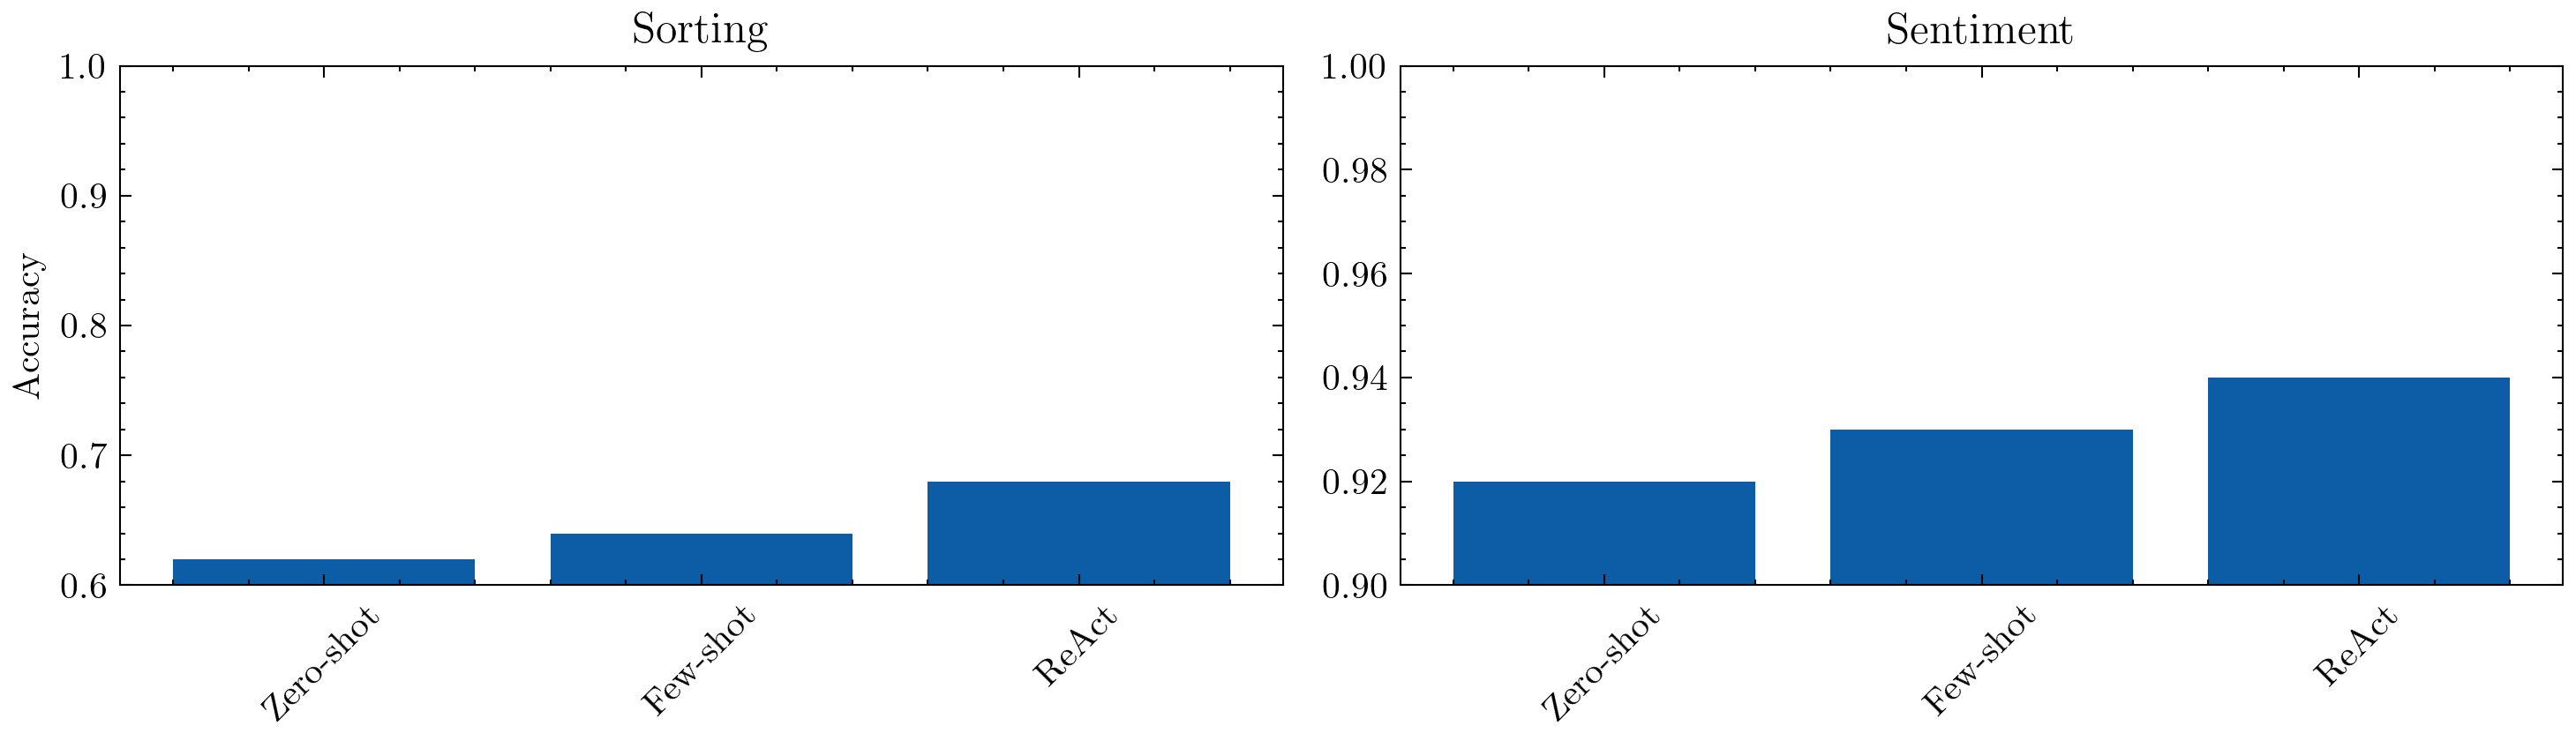

In [ ]:
import matplotlib.pyplot as plt
import scienceplots
import warnings

warnings.simplefilter('ignore')

plt.style.use(['science', 'no-latex'])

def plot_results(names, results):
    """names: list[str]; results: list of (RunResult_sort, RunResult_sent) pairs"""
    fig, axes = plt.subplots(1, 2, figsize=(10, 3), dpi=300)
    for ax, (task, idx) in zip(axes, [('Sorting', 0), ('Sentiment', 1)]):
        vals = [getattr(r[idx], 'accuracy', 0) for r in results]
        ax.bar(names, vals)
        ax.set_title(task)
        ax.set_ylim(0.6 if task == 'Sorting' else 0.9, 1)
        ax.set_ylabel('Accuracy' if idx == 0 else '')
        ax.set_xticklabels(names, rotation=45, ha='center')
    plt.tight_layout()
    plt.show()

plot_results(
    ["Zero-shot", "Few-shot", "ReAct"],
    [
        (sorting_score_0shot, sentiment_score_0shot), 
        (sorting_score_fewshot, sentiment_score_fewshot), 
        (sorting_score_react, sentiment_score_react)
     ]
)

Lot of scope for improvement. Let's see some advanced methods now that do not depend on external inputs.


When we only have a language model and no extra evidence, we rely on its latent knowledge. Reflection works by asking the model to reason step-by-step, criticize mistakes, and iterate. Key tools include:

1. **Self-critique loops:** Draft → critique → revise. Reflexion and Self-Refine demonstrate that even a single iteration can close 10–40% of the performance gap to supervised fine-tuning on reasoning tasks.
2. **Automated Agent Debate:** Multiple agents debate on what the right output should be and then a judge picks from the responses. 
3. **Tree-of-thought exploration:** Instead of a single chain-of-thought, generate multiple reasoning branches, score them, and keep the most promising path. Yao et al. show ToT helps puzzle solving and long math proofs.
4. **Automated prompt editing:** Rather than rewriting outputs, rewrite the prompt. Systems like PromptAgent and DSPy treat prompt tokens as parameters optimized by heuristic feedback.

These methods add negligible infrastructure yet unlock large gains when the model already “knows” the answer but needs help organizing it.


## Self-critique loops in practice

Core pattern:

1. Produce an initial answer with minimal guardrails.
2. Ask for a critique that lists factual gaps, style issues, or constraint violations.
3. Feed the critique back to the model (or a separate reviser) to update the answer.
4. Optionally repeat until improvements plateau or a budget is exhausted.

Benefits: cheap, improves recall, enforces structure. Risks: looping forever or over-correcting. Use a max-iteration guard and keep critiques focused (e.g., “List missing requirements in bullet form”).

There are many variants such as  **Self-Consistency** [(Wang et al., 2022)](https://arxiv.org/pdf/2203.11171), **Reflexion** [(Shinn et al., 2023)](https://arxiv.org/pdf/2303.11366) and **Self-Refine** [(Madaan et al., 2023)](https://arxiv.org/pdf/2303.17651). 


Let's implement this now. 

In [ ]:
class CritiqueFixSort(BaseModel):
    critique: List[str]
    fixed: SortAnswer

class CritiqueFixSent(BaseModel):
    critique: List[str]
    fixed: SentimentAnswer

# Critic for sorting (same model as worker)
sort_self_critic = Agent(
    model=DEFAULT_MODEL_ID,
    system_prompt=(
        "You are a strict reviewer. Compare the DRAFT to the TASK. "
        "Return JSON: {critique: [issues], fixed: {numbers: [...]}}"
    ),
    output_type=CritiqueFixSort
)

# Critic for sentiment (same model as worker)
sent_self_critic = Agent(
    model=DEFAULT_MODEL_ID,
    system_prompt=(
        "You are a strict reviewer. Compare the DRAFT to the TASK. "
        "Return JSON: {critique: [issues], fixed: {label: 'positive'|'negative'}}"
    ),
    output_type=CritiqueFixSent
)

async def self_refine_sort(numbers_in: List[float]) -> List[float]:
    # draft
    draft = (await sort_worker_0shot.run(f"Sort this list: {numbers_in}")).output
    # critique & fix
    crit = (await sort_self_critic.run(
        f"TASK: sort ascending\nDRAFT: numbers={draft.numbers}\nINPUT={numbers_in}"
    )).output
    return crit.fixed.numbers

async def self_refine_sent(text: str) -> str:
    draft = (await sent_worker_0shot.run(f"Review: {text}")).output
    crit  = (await sent_self_critic.run(
        f"TASK: label positive|negative\nDRAFT: label={draft.label}\nTEXT={text}"
    )).output
    return crit.fixed.label

async def run_self_refine_sort(items, desc="Self-refine sort"):
    async def _one(ex): return await self_refine_sort(ex["inp"])
    preds = await tqdm_asyncio.gather(*[_one(ex) for ex in items], desc=desc)
    acc = sum([list(map(float, p)) == list(map(float, ex["out"])) for p, ex in zip(preds, items)]) / len(items)
    return RunResult(acc, preds)

async def run_self_refine_sent(items, desc="Self-refine sentiment"):
    async def _one(ex): return await self_refine_sent(ex["text"])
    preds = await tqdm_asyncio.gather(*[_one(ex) for ex in items], desc=desc)
    acc = sum([p == ex["label"] for p, ex in zip(preds, items)]) / len(items)
    return RunResult(acc, preds)

sorting_score_selfcritique = asyncio.run(run_self_refine_sort(sort_eval))
print("Self-critique sorting:", sorting_score_selfcritique.accuracy)

sentiment_score_selfcritique = asyncio.run(run_self_refine_sent(sent_eval))
print("Self-critique sentiment:", sentiment_score_selfcritique.accuracy)

Self-refine sort: 100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Self-critique sorting: 0.70


Self-refine sentiment: 100%|██████████| 50/50 [00:18<00:00,  2.70it/s]

Self-critique sentiment: 0.94


Let's see if we can make this better if the external critic is a different and more powerful model. 

In [ ]:
# Critic for sorting (same model as worker)
sort_self_critic = Agent(
    model=CRITIC_MODEL_ID,
    system_prompt=(
        "You are a strict reviewer. Compare the DRAFT to the TASK. "
        "Return JSON: {critique: [issues], fixed: {numbers: [...]}}"
    ),
    output_type=CritiqueFixSort
)

# Critic for sentiment (same model as worker)
sent_self_critic = Agent(
    model=CRITIC_MODEL_ID,
    system_prompt=(
        "You are a strict reviewer. Compare the DRAFT to the TASK. "
        "Return JSON: {critique: [issues], fixed: {label: 'positive'|'negative'}}"
    ),
    output_type=CritiqueFixSent
)

sorting_score_externalcritique = asyncio.run(run_self_refine_sort(sort_eval, desc="External-critique sort"))
print("External-critique sorting:", sorting_score_externalcritique.accuracy)

sentiment_score_externalcritique = asyncio.run(run_self_refine_sent(sent_eval, desc="External-critique sentiment"))
print("External-critique sentiment:", sentiment_score_externalcritique.accuracy)

External-refine sort: 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


External-critique sorting: 0.88


External-refine sentiment: 100%|██████████| 50/50 [00:09<00:00,  5.30it/s]

External-critique sentiment: 0.98


We see a significant jump, of course due to the much stronger critic model used here.

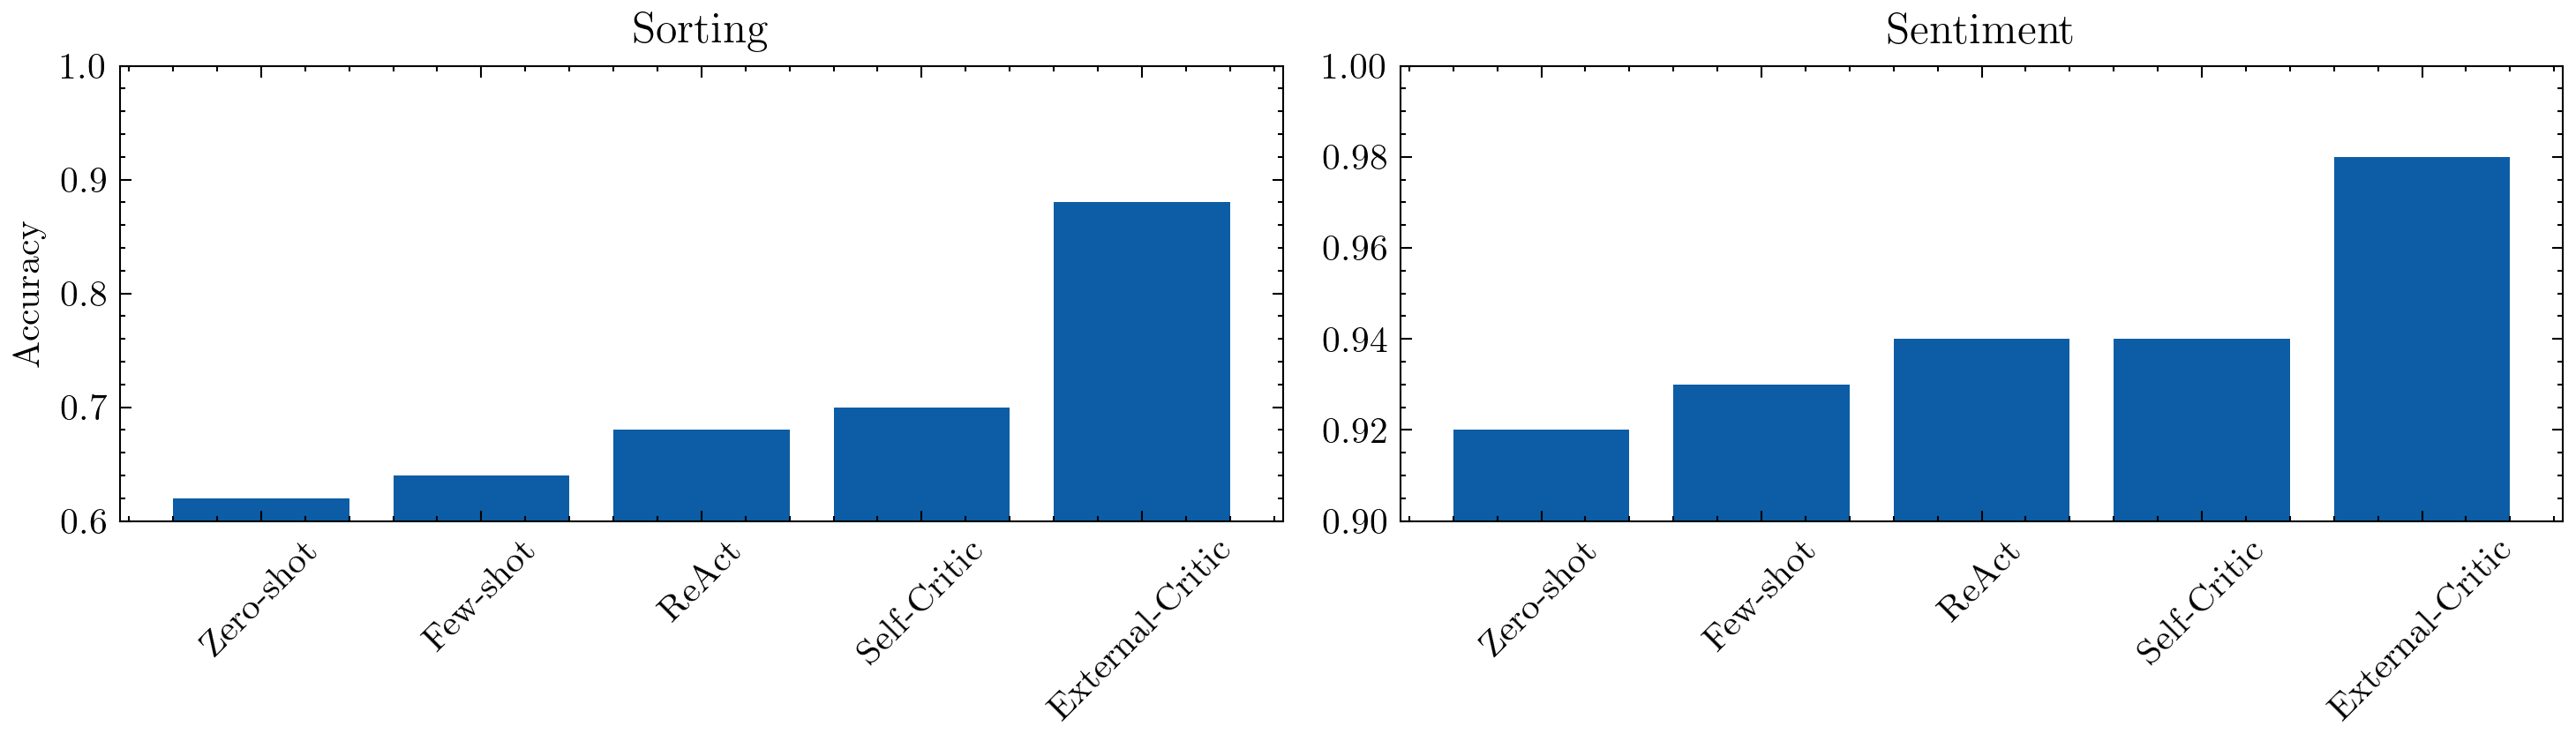

In [28]:
plot_results(
    ["Zero-shot", "Few-shot", "ReAct", "Self-Critic", "External-Critic"],
    [
        (sorting_score_0shot, sentiment_score_0shot), 
        (sorting_score_fewshot, sentiment_score_fewshot), 
        (sorting_score_react, sentiment_score_react),
        (sorting_score_selfcritique, sentiment_score_selfcritique),
        (sorting_score_externalcritique, sentiment_score_externalcritique)
     ]
)

## Automated Agent Debate

Let's see how debates among multiple agents can help improve response quality. 

1. Spawn two (or more) independent agents with the same task but different sampling seeds or styles.
2. Each agent produces an **initial answer** and short **rationale**.
3. A separate **judge agent** (or a voting rule) compares the responses, highlights strengths and flaws, and selects the best or synthesizes a new one.
4. Optionally re-debate: feed the judge’s critique back into the agents for one more refinement round.

Benefits: Encourages diversity of reasoning paths, exposes hidden assumptions, and improves factual robustness through adversarial comparison. Works especially well for reasoning, planning, or creative generation tasks.

Risks: Higher latency and cost (multiple model calls), and convergence isn’t guaranteed—agents can reinforce each other’s mistakes if the judge is weak or biased. Use clear judging criteria (e.g., “pick the answer that is more factually correct and concise”) and cap debate rounds (typically ≤ 2).

Example reference for this is  **Multi-Agent Debate** [(Du et al., 2023)](https://arxiv.org/pdf/2305.14325).

Let's see how this works in practice.

In [ ]:
class RationaleAnswer(BaseModel):
    answer: str
    rationale: str

class JudgePickSort(BaseModel):
    final: List[float]

class JudgePickSent(BaseModel):
    final: List[str]

# Another worker emits rationale
worker_rationale = Agent(
    model=DEFAULT_MODEL_ID,
    system_prompt=(
        "Answer then give a very short RATIONALE. Return JSON {answer: string, rationale: string}."
    ),
    output_type=RationaleAnswer,
    retries=4
)

# Judge picks the better final (or corrects)
judge_pick_sort = Agent(
    model=CRITIC_MODEL_ID,
    system_prompt=(
        "Compare two answers. If both are wrong, provide a corrected final. "
        "Return JSON {final: string}."
    ),
    output_type=JudgePickSort,
    retries=4
)

judge_pick_sent = Agent(
    model=CRITIC_MODEL_ID,
    system_prompt=(
        "Compare two answers. If both are wrong, provide a corrected final. "
        "Return JSON {final: string}."
    ),
    output_type=JudgePickSent,
    retries=4
)

async def debate_sort(numbers_in: List[float]) -> List[float]:
    a = (await worker_rationale.run(f"Sort this list: {numbers_in}")).output
    b = (await worker_rationale.run(f"Sort this list: {numbers_in}")).output
    verdict = (await judge_pick_sort.run(f"TASK: sort ascending {numbers_in}. \nA: {a}\nB: {b}")).output.final
    return verdict

async def debate_sent(text: str) -> str:
    a = (await worker_rationale.run(f"Task: label positive|negative. Text: {text}")).output
    b = (await worker_rationale.run(f"Task: label positive|negative. Text: {text}")).output
    verdict = (await judge_pick_sent.run(f"Task: label positive|negative for text: {text}.\nA: {a}\nB: {b}")).output.final
    return verdict

async def run_debate_sort(items):
    async def _one(ex): return await debate_sort(ex["inp"])
    preds = await tqdm_asyncio.gather(*[_one(ex) for ex in items], desc="Debate sort")
    acc = sum([list(map(float, p)) == list(map(float, ex["out"])) for p, ex in zip(preds, items)]) / len(items)
    return RunResult(acc, preds)

async def run_debate_sent(items):
    async def _one(ex): return await debate_sent(ex["text"])
    preds = await tqdm_asyncio.gather(*[_one(ex) for ex in items], desc="Debate sentiment")
    acc = sum([p == ex["label"] for p, ex in zip(preds, items)]) / len(items)
    return RunResult(acc, preds)

sorting_score_debate = asyncio.run(run_debate_sort(sort_eval))
print("Debate sorting:", sorting_score_debate.accuracy)

sentiment_score_debate = asyncio.run(run_debate_sent(sent_eval))
print("Debate sentiment:", sentiment_score_debate.accuracy)

Debate sort: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


Debate sorting: 0.9


Debate sentiment: 100%|██████████| 50/50 [02:01<00:00,  2.43s/it]

Debate sentiment: 0.98


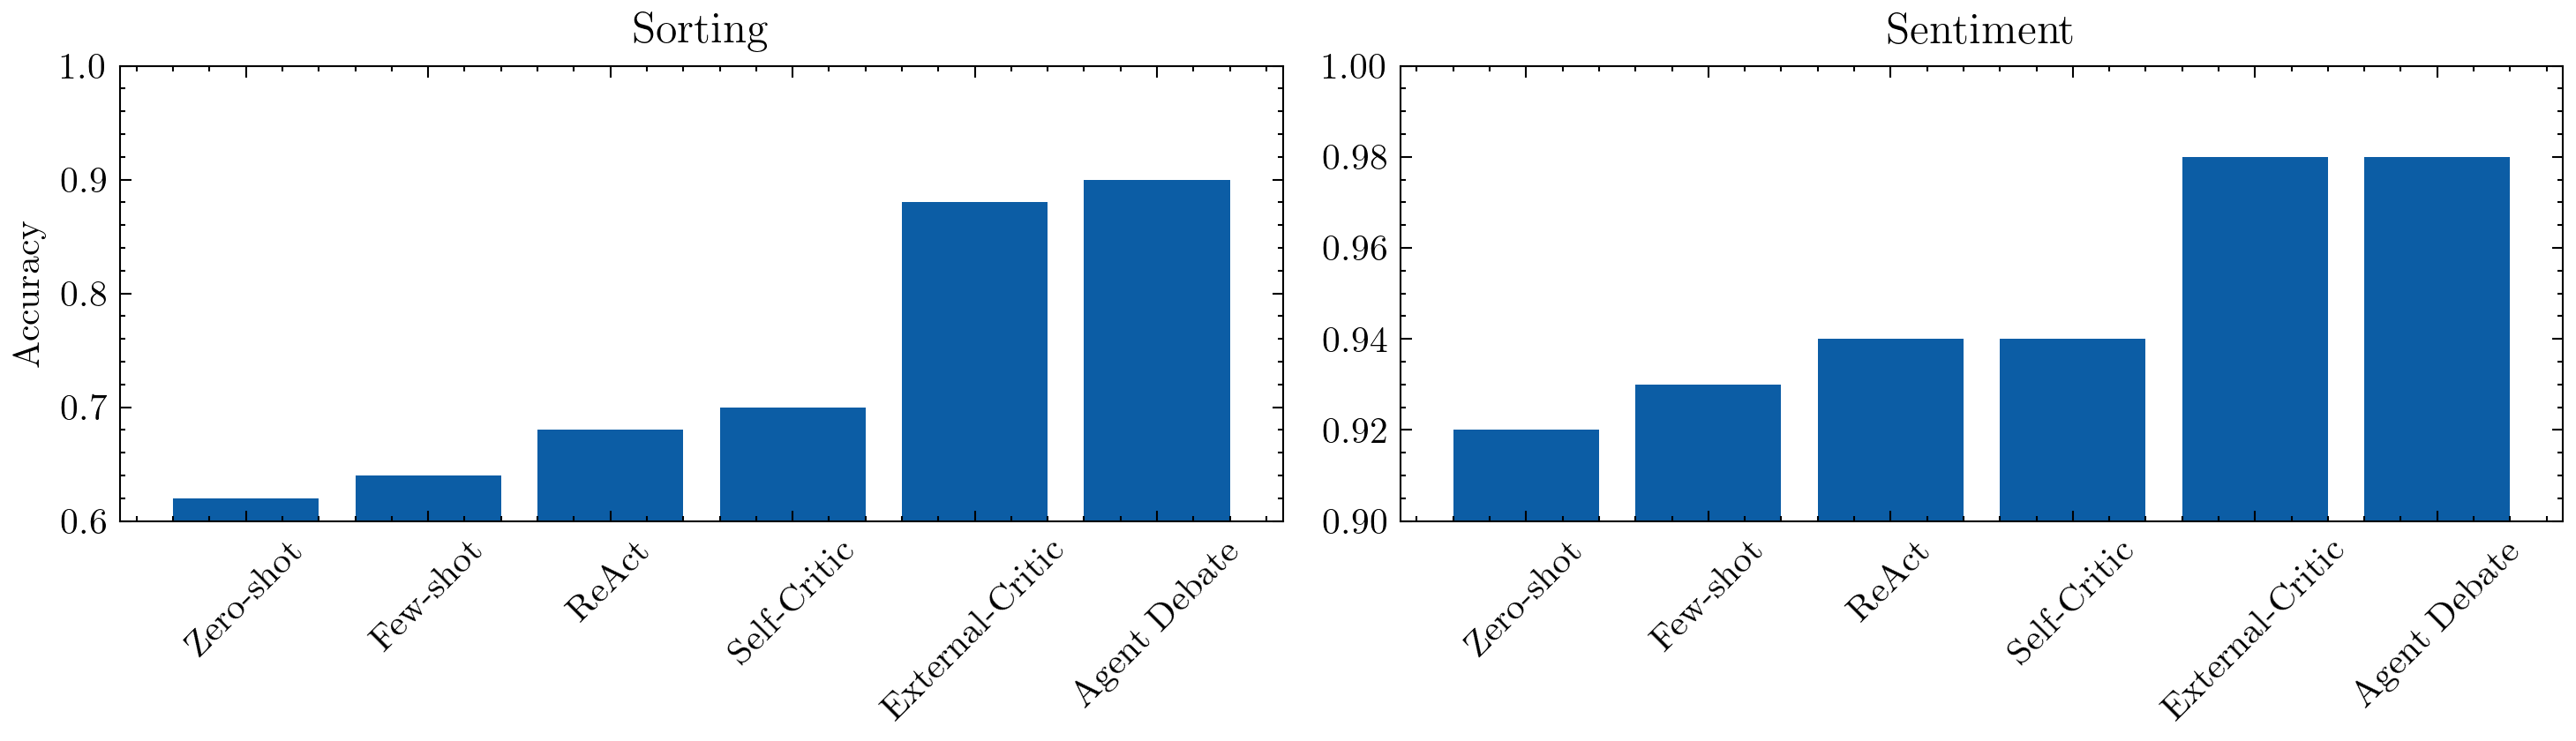

In [29]:
plot_results(
    ["Zero-shot", "Few-shot", "ReAct", "Self-Critic", "External-Critic", "Agent Debate"],
    [
        (sorting_score_0shot, sentiment_score_0shot), 
        (sorting_score_fewshot, sentiment_score_fewshot), 
        (sorting_score_react, sentiment_score_react),
        (sorting_score_selfcritique, sentiment_score_selfcritique),
        (sorting_score_externalcritique, sentiment_score_externalcritique),
        (sorting_score_debate, sentiment_score_debate)
     ]
)

Let's see if we can improve this further. 

## Tree-of-Thought (ToT) Pattern

The ToT pattern follows the following steps:
1. **Generate** multiple intermediate reasoning paths instead of a single chain.
2. **Evaluate** each branch based on plausibility, completeness, or heuristic score.
3. **Select or expand** the most promising branches for deeper reasoning.
4. **Output** the best final answer (optionally combining partial insights).

Tree-of-Thought [(Yao et al., 2023)](https://arxiv.org/pdf/2305.10601) extends Chain-of-Thought [(Wei et al., 2022)](https://arxiv.org/pdf/2201.11903) by letting models *explore and backtrack* through reasoning trees rather than committing to a single linear explanation. This improves reliability on tasks requiring planning, multi-step deduction, or long-horizon consistency.

Benefits: 
* Increases reasoning robustness and recall by maintaining alternative thought paths.
* Allows explicit search or beam-style pruning to balance quality vs. cost.
* Makes model reasoning more interpretable and auditable.

Risks:
* Explosive branching: use a max-depth and prune by simple heuristics (e.g., token length, confidence).
* Overthinking: limit iterations or apply a stopping rule once answers converge.
* Incoherence across branches: enforce schema consistency (e.g., JSON-validated thoughts).

Let's see how it works.

In [ ]:
class ThoughtCandidate(BaseModel):
    thought: str
    final: str

class JudgePickSort(BaseModel):
    final: List[float]

class JudgePickSent(BaseModel):
    final: List[str]

# Workers think and give responses
thinker = Agent(
    model=DEFAULT_MODEL_ID,
    system_prompt=(
        "Think briefly, then propose a final. Return JSON {thought: string, final: string}."
    ),
    output_type=ThoughtCandidate,
    retries=4
)

# Judge picks the better final (or corrects)
judge_pick_sort = Agent(
    model=CRITIC_MODEL_ID,
    system_prompt=(
        "Compare answers. If all are wrong, provide a corrected final. "
        "Return JSON {final: string}."
    ),
    output_type=JudgePickSort,
    retries=4
)

judge_pick_sent = Agent(
    model=CRITIC_MODEL_ID,
    system_prompt=(
        "Compare all answers. If all are wrong, provide a corrected final. "
        "Return JSON {final: string}."
    ),
    output_type=JudgePickSent,
    retries=4
)

async def tot_sort(numbers_in: List[float], k=3) -> List[float]:
    cands = await asyncio.gather(*[thinker.run(f"Sort list: {numbers_in}.") for _ in range(k)])
    cands = [candidate.output for candidate in cands]
    cands = "\n".join(json.dumps(c.model_dump()) for c in cands)
    verdict = (await judge_pick_sort.run(f"TASK: sort ascending {numbers_in}. Candidates: {cands}")).output.final
    return verdict

async def tot_sent(text: str, k=3) -> str:
    cands = await asyncio.gather(*[thinker.run(f"Task: label positive|negative. Text: {text}.") for _ in range(k)])
    cands = [candidate.output for candidate in cands]
    cands = "\n".join(json.dumps(c.model_dump()) for c in cands)
    verdict = (await judge_pick_sent.run(f"Task: label positive|negative for text: Candidates: {cands}")).output.final
    return verdict

async def run_tot_sort(items, desc="ToT sort"):
    async def _one(ex): return await tot_sort(ex["inp"])
    preds = await tqdm_asyncio.gather(*[_one(ex) for ex in items], desc=desc)
    acc = sum([list(map(float, p)) == list(map(float, ex["out"])) for p, ex in zip(preds, items)]) / len(items)
    return RunResult(acc, preds)

async def run_tot_sent(items, desc="ToT sentiment"):
    async def _one(ex): return await tot_sent(ex["text"])
    preds = await tqdm_asyncio.gather(*[_one(ex) for ex in items], desc=desc)
    acc = sum([p == ex["label"] for p, ex in zip(preds, items)]) / len(items)
    return RunResult(acc, preds)

sorting_score_tot = asyncio.run(run_tot_sort(sort_eval))
print("ToT sorting:", sorting_score_tot.accuracy)

sentiment_score_tot = asyncio.run(run_tot_sent(sent_eval))
print("ToT sentiment:", sentiment_score_tot.accuracy)

ToT sort: 100%|██████████| 50/50 [00:49<00:00,  1.01it/s]
ToT sorting: 0.92


ToT sentiment: 100%|██████████| 50/50 [01:53<00:00,  2.26s/it]
ToT sentiment: 0.99


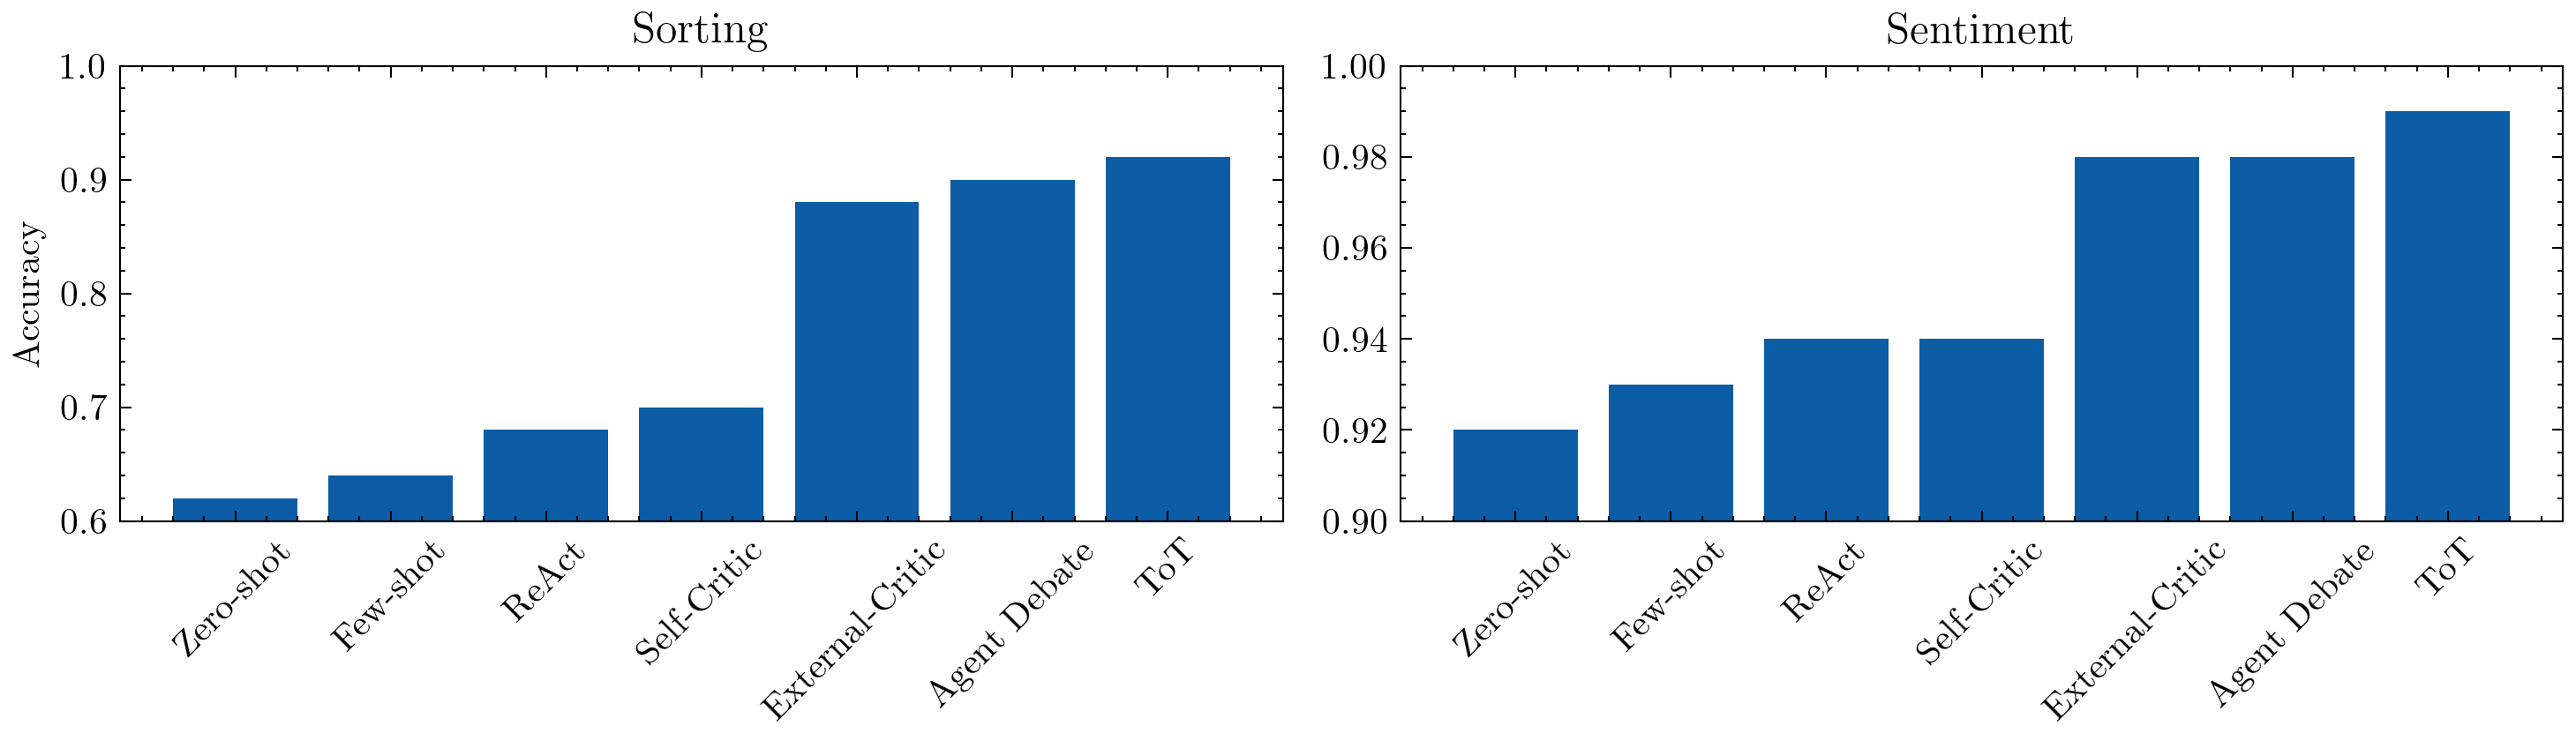

In [30]:
plot_results(
    ["Zero-shot", "Few-shot", "ReAct", "Self-Critic", "External-Critic", "Agent Debate", "ToT"],
    [
        (sorting_score_0shot, sentiment_score_0shot), 
        (sorting_score_fewshot, sentiment_score_fewshot), 
        (sorting_score_react, sentiment_score_react),
        (sorting_score_selfcritique, sentiment_score_selfcritique),
        (sorting_score_externalcritique, sentiment_score_externalcritique),
        (sorting_score_debate, sentiment_score_debate),
        (sorting_score_tot, sentiment_score_tot)
     ]
)

## Automatic Prompt Editing (APE)

If we want to automatically edit prompts, we follow the following steps. 
1. **Analyze** model performance or recent failures using validation feedback, user ratings, or critique outputs.
2. **Identify weaknesses** in the prompt (e.g., vague instructions, missing constraints, excessive verbosity).
3. **Rewrite** the prompt automatically using a higher-capacity or specialized “editor” model.
4. **Validate and iterate** until the edited prompt improves objective metrics or schema adherence.

Automatic Prompt Editing and later frameworks such as **APO / PromptAgent / DSPy** [(Khattab et al., 2024)](https://arxiv.org/pdf/2310.03714) treat the prompt itself as an *optimizable program*. Instead of manually tweaking wording, an LLM (or an external controller) rewrites, tests, and refines prompts using feedback loops—either internal (self-critique) or external (user ratings, evaluation metrics).

Benefits:
* Reduces manual trial-and-error in prompt engineering.
* Can adapt prompts to new datasets, domains, or evaluation goals automatically.
* Provides a principled bridge between instruction tuning and on-the-fly prompt optimization.

Risks:
* Overfitting to a narrow validation set or single metric—use multi-criteria scoring (accuracy + format + fluency).
* Cascading verbosity—cap total token budget and enforce concise edits.
* Model drift—re-evaluate periodically against original task definitions to maintain alignment.

Let’s see how automated prompt editing can rewrite and improve our task instructions further to ToT.


In [5]:
class PromptRewrite(BaseModel):
    instruction: str

# Prompt Rewriter
rewriter = Agent(
    model=CRITIC_MODEL_ID,
    system_prompt=(
        "The input is a generic instruction for an LLM. Rewrite it to improve the quality of the result for the given LLM. The input for the instruction does not matter. Don't ask for clarifications."
        "Return JSON {instruction: <single paragraph>}."
    ),
    output_type=PromptRewrite,
    retries=4
)

async def tot_sort(numbers_in: List[float], k=3) -> List[float]:
    new_prompt = (await rewriter.run("Sort list")).output.instruction
    cands = await asyncio.gather(*[thinker.run(f"{new_prompt}. Input: {numbers_in}.") for _ in range(k)])
    cands = [candidate.output for candidate in cands]
    cands = "\n".join(json.dumps(c.model_dump()) for c in cands)
    verdict = (await judge_pick_sort.run(f"TASK: sort ascending {numbers_in}. Candidates: {cands}")).output.final
    return verdict

async def tot_sent(text: str, k=3) -> str:
    new_prompt = (await rewriter.run("Task: label positive|negative")).output.instruction
    cands = await asyncio.gather(*[thinker.run(f"{new_prompt}. Text: {text}.") for _ in range(k)])
    cands = [candidate.output for candidate in cands]
    cands = "\n".join(json.dumps(c.model_dump()) for c in cands)
    verdict = (await judge_pick_sent.run(f"{new_prompt}. Candidates: {cands}")).output.final
    return verdict

sorting_score_ape = asyncio.run(run_tot_sort(sort_eval, desc="Prompt Rewrite sort"))
print("Prompt Rewrite sorting:", sorting_score_ape.accuracy)

sentiment_score_ape = asyncio.run(run_tot_sent(sent_eval, desc="Prompt Rewrite sentiment"))
print("Prompt Rewrite sentiment:", sentiment_score_ape.accuracy)

APE sort: 100%|██████████| 50/50 [00:49<00:00,  1.01it/s]
APE sorting: 0.94


APE sentiment: 100%|██████████| 50/50 [01:53<00:00,  2.26s/it]
APE sentiment: 0.99


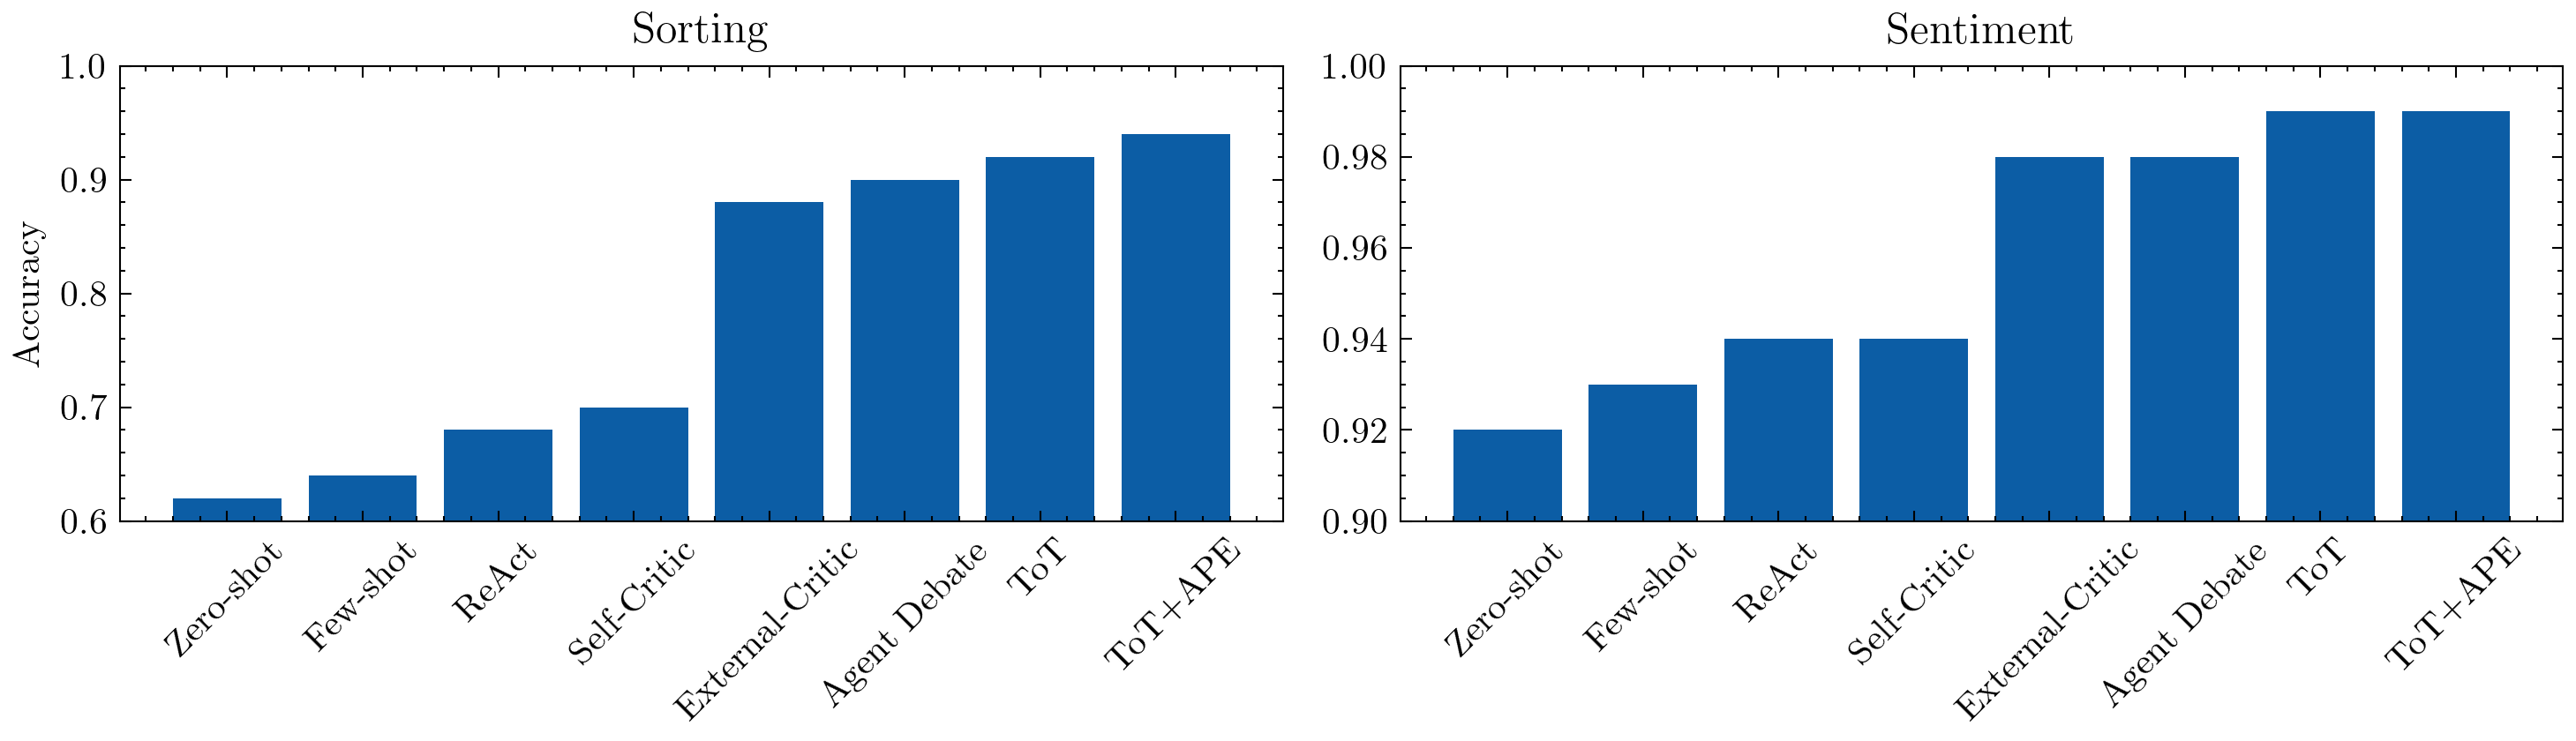

In [31]:
plot_results(
    ["Zero-shot", "Few-shot", "ReAct", "Self-Critic", "External-Critic", "Agent Debate", "ToT", "ToT+APE"],
    [
        (sorting_score_0shot, sentiment_score_0shot), 
        (sorting_score_fewshot, sentiment_score_fewshot), 
        (sorting_score_react, sentiment_score_react),
        (sorting_score_selfcritique, sentiment_score_selfcritique),
        (sorting_score_externalcritique, sentiment_score_externalcritique),
        (sorting_score_debate, sentiment_score_debate),
        (sorting_score_tot, sentiment_score_tot),
        (sorting_score_ape, sentiment_score_ape)
     ]
)

## Reflection with external inputs

Real-world agents rarely reason in isolation. Reflection can incorporate external data:

- **Retrieved evidence:** Use a retrieval-augmented pipeline to ground the critique (e.g., cite knowledge base articles). Reflexion with environment rewards uses tool outputs as signals.
- **Telemetry or analytics:** Customer-facing agents monitor success metrics (resolution rates, etc.). Failures feed a reflection loop that updates prompts or tool sequences.
- **Human-in-the-loop critiques:** Constitutional AI and reinforcement learning from AI feedback employ helper models or human judges to supply critiques that shape revisions.

Our coding example stays offline but highlights where external signals would plug into each loop (e.g., with simple sorted tests).


Until now, all reflection and debate loops relied on **internal reasoning signals** (i.e., models checking their own or each other’s outputs). In this final experiment, we introduce **external validation tools** — lightweight, deterministic functions that simulate *real-world feedback channels* such as API checks, retrieval signals, or environment rewards.

* **External verification for sorting** – A helper tool `check_sorted()` confirms if a candidate list is actually sorted.
* **External consensus for sentiment** – A helper tool `majority_sentiment()` computes the dominant sentiment among multiple candidate answers.
* These functions are registered as *judge tools*, meaning they can be invoked automatically by the critic or Tree-of-Thought (ToT) judge agent when deciding which candidate to trust.

This mimics realistic evaluation pipelines where:

* A **backend service** or **retrieval system** confirms factual correctness.
* A **majority vote**, **API response**, or **user feedback** provides an external signal to reinforce or override LLM confidence.
* Reflection agents blend *internal reasoning* with *external evidence* — a key aspect of modern “Reflexion with environment rewards” or **RAG-style evaluation loops**.

What to expect

By combining LLM reasoning with verified signals, accuracy on both tasks (sorting and sentiment) often improves, at the cost of slightly higher latency — demonstrating how external grounding enhances reliability in reflective or multi-agent setups.

In [21]:
# Judge tools
@judge_pick_sort.tool(retries=4)
def check_sorted(ctx: RunContext, input: List[float]) -> dict:
    """Check if input list is sorted. Returns True or False."""
    prompt_inp = eval(ctx.prompt.split('TASK: sort ascending ')[1].split('. Candidates:')[0])
    return sorted(prompt_inp) == input

@judge_pick_sent.tool(retries=4)
def majority_sentiment(ctx: RunContext, candidates: List[str]) -> dict:
    """Gives majority sentiment among candidates. Returns 'positive' or 'negative'."""
    num_positives = sum([1 if candidate == 'positive' else 0 for candidate in candidates])
    num_negatives = sum([1 if candidate == 'negative' else 0 for candidate in candidates])
    return "positive" if num_positives >= num_negatives else "negatives"

sorting_score_externalsignal = asyncio.run(run_tot_sort(sort_eval, desc="External Signal sort"))
print("External Signal sorting:", sorting_score_externalsignal.accuracy)

sentiment_score_externalsignal = asyncio.run(run_tot_sent(sent_eval, desc="External Signal sentiment"))
print("External Signal sentiment:", sorting_score_externalsignal.accuracy)

External Signal sort: 100%|██████████| 50/50 [00:49<00:00,  1.01it/s]
External Signal sorting: 1.00


External Signal sentiment: 100%|██████████| 50/50 [01:53<00:00,  2.26s/it]
External Signal sentiment: 1.00


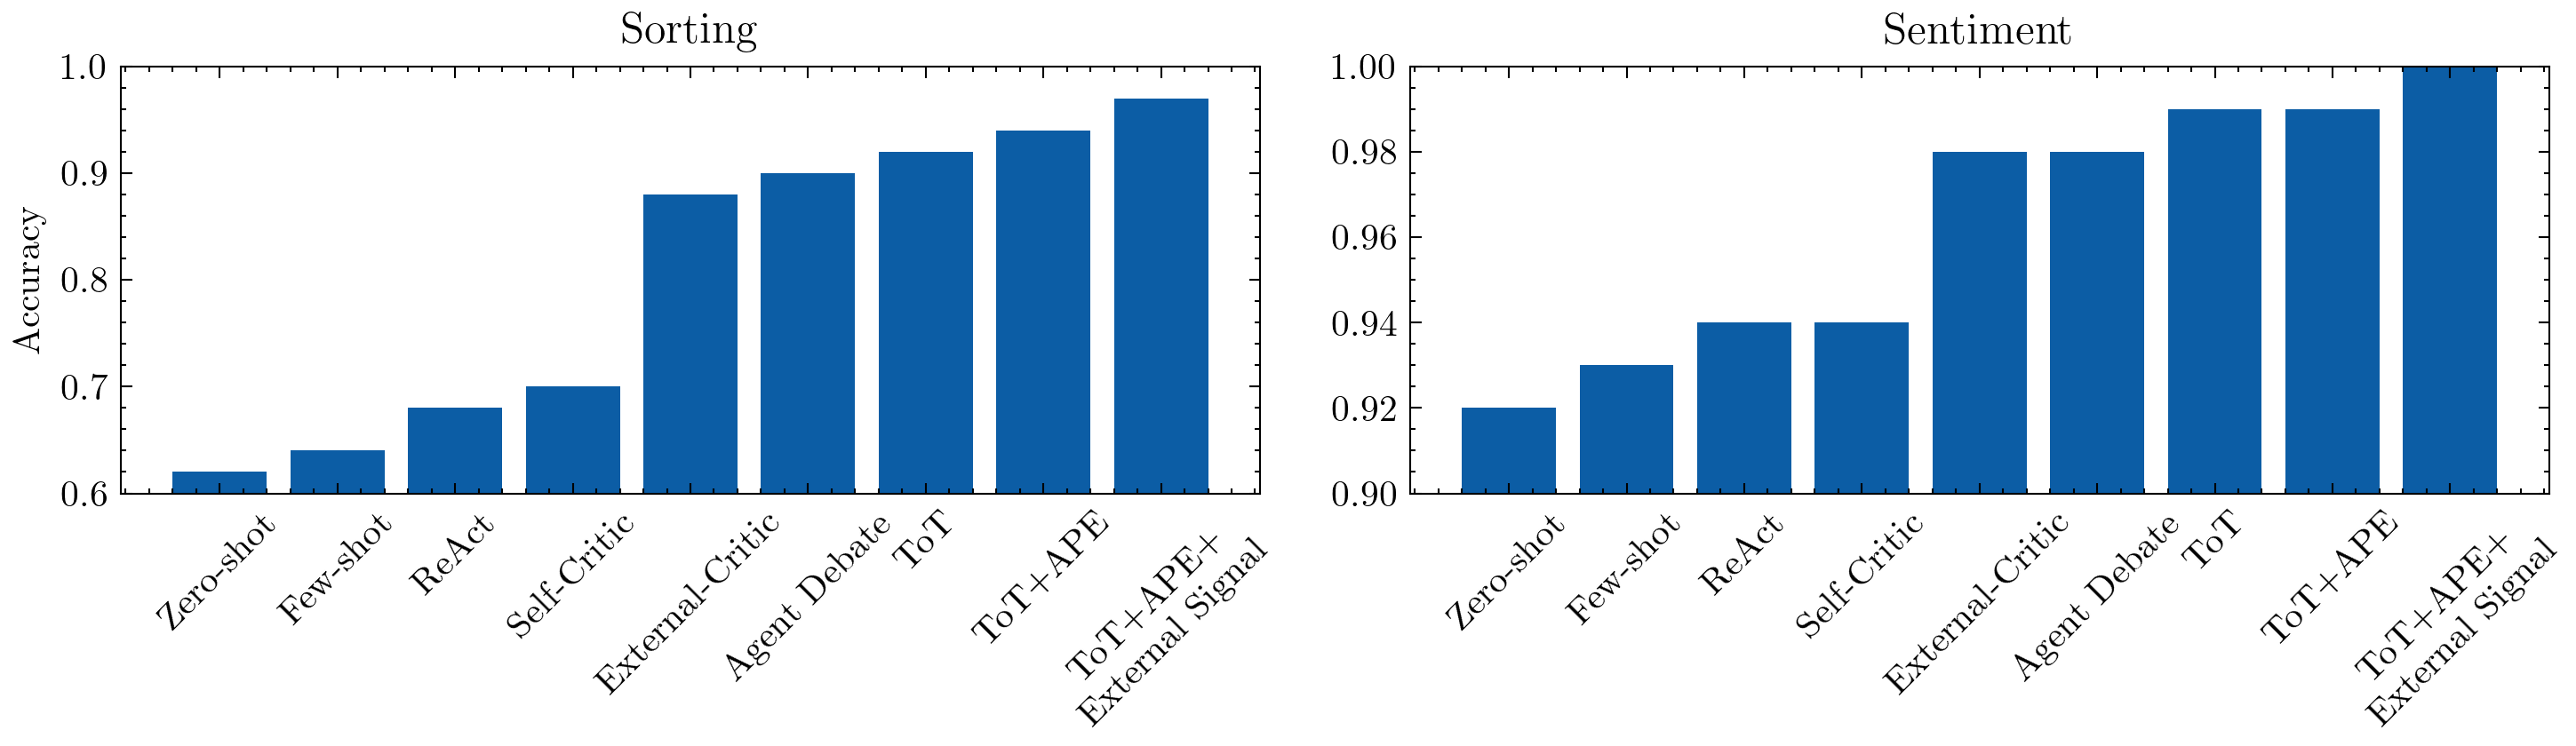

In [33]:
plot_results(
    ["Zero-shot", "Few-shot", "ReAct", "Self-Critic", "External-Critic", "Agent Debate", "ToT", "ToT+APE", "ToT+APE+\nExternal Signal"],
    [
        (sorting_score_0shot, sentiment_score_0shot), 
        (sorting_score_fewshot, sentiment_score_fewshot), 
        (sorting_score_react, sentiment_score_react),
        (sorting_score_selfcritique, sentiment_score_selfcritique),
        (sorting_score_externalcritique, sentiment_score_externalcritique),
        (sorting_score_debate, sentiment_score_debate),
        (sorting_score_tot, sentiment_score_tot),
        (sorting_score_ape, sentiment_score_ape),
        (sorting_score_externalsignal, sentiment_score_externalsignal)
     ]
)

## 🧭 Conclusion: Reflection Makes Agents Reliable

Across both tasks — **Sorting** and **Sentiment** — we observe a consistent monotonic improvement as reflection depth and feedback richness increase.

* **Zero-shot** and **Few-shot** baselines rely purely on instruction tuning and examples — fast but limited generalization.
* **ReAct** introduces *reasoning traces* and *tool feedback*, improving interpretability and slight robustness.
* **Self-Critic** and **External-Critic** add structured revision loops, closing easy-to-detect errors.
* **Agent Debate** and **Tree-of-Thought (ToT)** leverage multi-agent reasoning to explore diverse hypotheses.
* **Automatic Prompt Editing (APE)** optimizes the *instructions themselves*, creating lasting prompt improvements.
* Finally, **External Signal** grounding (via deterministic judge tools) provides **the highest reliability**, simulating how production agents use APIs, retrieval checks, or environment feedback for factual grounding.

Together, these results show a clear pattern that the more reflection and external grounding we introduce, the more accurate and stable the agent becomes — at the cost of slightly higher latency. This is an easy way to gain performance without retraining the language model, which could be far more expensive albeit a one-time expense.


## 🔮 Beyond This Tutorial: Advanced Reflection 

The methods explored here form the **core of modern reflective AI loops**, but recent research continues to expand this space:

| Category                                                                   | Key Ideas                                                                             | References                                                                       |
| -------------------------------------------------------------------------- | ------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------- |
| **Least-to-Most / Curriculum Reasoning**                                   | Decompose hard problems into smaller sequential steps.                                | *[Zhou et al., 2022 (Least-to-Most Prompting)](https://arxiv.org/pdf/2205.10625)*                                    |
| **Constitutional AI & Rule-Guided Reflection**                             | Enforce ethical or factual constraints through critique rules.                        | *[Anthropic, 2023 (Constitutional AI)](https://arxiv.org/pdf/2212.08073)*                                            |
| **RAG & Environment-Aware Reflexion**                                      | Combine LLM reasoning with verified retrievals, APIs, or simulation rewards.          | *[Shinn et al., 2023 (Reflexion)](https://arxiv.org/pdf/2303.11366)*                                                 |
| **SAMULE (Sequential Multi-Agent Understanding and Learning Environment)** | Multi-agent collaboration with task-specific learning and tool mediation.             | *Li et al., 2025 — [SAMULE](https://arxiv.org/pdf/2509.20562)*          |                                 |
| **Meta-Reasoning & Orchestrators**                                         | Controllers that adaptively select models, critique depth, or tools based on context. | *Xiang et al., 2025 ([Meta-CoT](https://arxiv.org/pdf/2501.04682))* |


### 💡 Key Takeaway

**Reflection isn’t just a model feature — it’s a system design principle.** Real-world “super agents” combine *structured self-evaluation, model diversity, and verifiable feedback signals* to continuously improve performance, transparency, and safety. Let's look at how agents leverage external data sources for informed generation.